In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
train_df = pd.read_csv('../../datasets/training_2nd_dataset.csv')
train_df['identifier'] = train_df['domain_name'] +'-'+ train_df['city'] +'-'+ train_df['isp'] +'-'+ train_df['node_name']

used_idx = train_df['identifier'].value_counts().index.tolist()[:-11547]
train_filtered = train_df.loc[train_df['identifier'].isin(used_idx)].copy()

In [3]:
sum(train_filtered['icmp_rtt'].values == 0.0)

1637

In [4]:
sum(train_filtered['icmp_lossrate'].values ==0.0)

877

In [5]:
train_filtered.shape

(7327290, 24)

In [6]:
train_filtered.drop(train_filtered[(train_filtered['icmp_lossrate'] == 0) & (train_filtered['icmp_rtt'] == 0)].index, inplace=True)

In [7]:
train_filtered.shape

(7326517, 24)

In [8]:
7327290-1637-877

7324776

In [9]:
from math import sqrt
def calculate_nctt(rtt, loss_rate):
    return 8 * rtt + loss_rate * 8 * 2.5


def calculate_throughput(rtt1, loss_rate):
    if (rtt1-0.0) < 1e-6 or (loss_rate-0.0) < 1e-6:
        return 10
    rtt = rtt1 / 1.5
    return 1460.0 / rtt / 1024 * (1 / sqrt(loss_rate)) # unit MB/s


def calculate_throughput_improved(rtt1, loss_rate):
    if (rtt1-0.0) < 1e-6 or (loss_rate-0.0) < 1e-6:
        return 10
    rtt = rtt1 / 1.5
    return min(4194304.0/rtt/1024, 1/(rtt*sqrt(4/3*loss_rate) +
                                      min(1, 3*sqrt(0.75*loss_rate))*loss_rate*(1+32*loss_rate*loss_rate)))

In [10]:
# train_filtered["nctt"] = train_df[["icmp_rtt", "icmp_lossrate"]].apply(lambda x : calculate_nctt(*x), axis=1)
train_filtered["bw_up"] = train_filtered[["tcp_conntime", "icmp_lossrate"]].apply(lambda x : calculate_throughput(*x), axis=1)
train_filtered["bw_im"] = train_filtered[["tcp_conntime", "icmp_lossrate"]].apply(lambda x : calculate_throughput_improved(*x), axis=1)

In [11]:
train_filtered['reverse_tcp'] = 1- train_filtered['synack1_ratio']

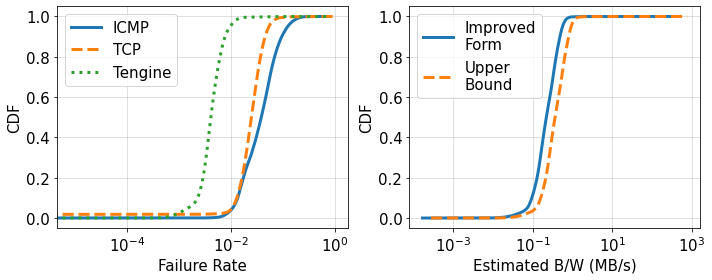

In [12]:
labels = ["ICMP", "TCP", "Tengine"]
cols = ['icmp_lossrate', 'reverse_tcp', 'ratio_499_5xx']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
lss = ['-', '--', ':','-.']
fig, axs = plt.subplots(1, 2, figsize = (10, 4))

ax0 = axs[0]
for i in range(len(labels)):
    ax0.plot(sorted(train_filtered[cols[i]].values),np.arange(len(train_filtered[cols[i]].values)) / len(train_filtered[cols[i]].values), 
             color=colors[i], ls=lss[i],linewidth=3, label=labels[i])
# ax0.plot(sorted(train_df['icmp_rtt'].values),np.arange(len(train_df['icmp_rtt'].values)) / len(train_df['icmp_rtt'].values), color='tab:blue', ls='-',linewidth=3, label="ICMP")
# ax0.plot(sorted(train_df['tcp_conntime'].values),np.arange(len(train_df['tcp_conntime'].values)) / len(train_df['tcp_conntime'].values), color='tab:orange', 
#          ls='--',linewidth=3, label="TCP")
ax0.grid(alpha=0.5)
# ax0.set_xlim(left=-0.1, right=2)
ax0.tick_params(axis='both', which='major', labelsize=15)
ax0.set_xscale('log')
ax0.set_xlabel('Failure Rate' , fontsize=15)
ax0.set_ylabel('CDF', fontsize=15)
ax0.legend(fontsize=15)

ax1 = axs[1]
ax1.plot(sorted(train_filtered['bw_im'].values), np.arange(len(train_filtered['bw_im'].values)) / len(train_filtered['bw_im'].values), 
         color='tab:blue', ls='-', linewidth=3, label="Improved\nForm")
ax1.plot(sorted(train_filtered['bw_up'].values), np.arange(len(train_filtered['bw_up'].values)) / len(train_filtered['bw_up'].values), 
         color='tab:orange', ls='--', linewidth=3, label="Upper\nBound")
# ax0.plot(sorted(train_df['buffer_rate'].values),np.arange(len(train_df['buffer_rate'].values)) / len(train_df['buffer_rate'].values), color='tab:orange', 
#          ls='--',linewidth=3, label="Ours")
ax1.grid(alpha=0.5)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.set_xscale('log')
ax1.set_xlabel('Estimated B/W (MB/s)' , fontsize=15)
ax1.set_ylabel('CDF', fontsize=15)
ax1.legend(fontsize=15)
# handles, labels = ax1.get_legend_handles_labels()

fig.tight_layout()
# s = fig.subplotpars
# wid = s.right-s.left
# bb=[s.left+wid/2+0.0425, s.top+0.06, wid/2-0.0425, 0.05]
# leg = fig.legend(handles, labels, bbox_to_anchor=bb, mode="expand", borderaxespad=0, bbox_transform=fig.transFigure, 
#                  handlelength=2, ncol=4, fontsize=14,handletextpad=0.5)

fig.tight_layout()
# fig.savefig('./qos_bw_lossrate.pdf', bbox_inches='tight')
# fig.savefig('../../latex/pvldbstyle-master/figures/qos_bw_lossrate.pdf', bbox_extra_artists=(leg,), bbox_inches='tight')